In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install timm ptflops optuna

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import scipy.io
import timm
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ptflops import get_model_complexity_info
import numpy as np
import matplotlib.pyplot as plt
import optuna

%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir = '/content/drive/MyDrive/심층신경망개론/'

In [ ]:
import scipy.io

setid = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))

train_ids = setid['trnid'][0]
valid_ids = setid['valid'][0]
test_ids = setid['tstid'][0]
image_labels = labels['labels'][0]

In [ ]:
class OxfordFlowersDataset(Dataset):
    def __init__(self, image_ids, labels, root_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, 'jpg', 'image_{:05d}.jpg'.format(img_id))
        image = Image.open(img_path).convert('RGB')
        label = self.labels[img_id - 1] - 1

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def cutmix_data(inputs, targets, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size, _, H, W = inputs.size()
    index = torch.randperm(batch_size).to(inputs.device)

    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    inputs[:, :, bby1:bby2, bbx1:bbx2] = inputs[index, :, bby1:bby2, bbx1:bbx2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size(-1) * inputs.size(-2)))

    targets_a, targets_b = targets, targets[index]
    return inputs, targets_a, targets_b, lam

def cutmix_criterion(criterion, outputs, targets_a, targets_b, lam):
    return lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = OxfordFlowersDataset(train_ids, image_labels, data_dir, transform=train_transforms)
valid_dataset = OxfordFlowersDataset(valid_ids, image_labels, data_dir, transform=val_test_transforms)
test_dataset = OxfordFlowersDataset(test_ids, image_labels, data_dir, transform=val_test_transforms)

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
weights_path = f'{data_dir}deit_tiny_patch16_224-a1311bcf.pth'

model = timm.create_model('deit_tiny_patch16_224', pretrained=False)

state_dict = torch.load(weights_path, map_location=device)

if 'model' in state_dict:
    state_dict = state_dict['model']

model.load_state_dict(state_dict)

model.head = nn.Linear(model.head.in_features, 102)
model = model.to(device)

<ipython-input-17-893c94047820>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


In [ ]:
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f"GFLOPs: {macs}")

GFLOPs: 913.66 MMac


In [ ]:
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-3, 1e-2, log=True)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=3,
        verbose=False,
        threshold=1e-4,
        threshold_mode='rel'
    )

    num_epochs = 10
    best_val_loss = float('inf')
    trigger_times = 0
    patience = 5

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False)

        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            cutmix_prob = 0.3
            r = np.random.rand(1)
            if r < cutmix_prob:
                inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels, alpha=0.5)
                outputs = model(inputs)
                loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if r < cutmix_prob:
                correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())
            else:
                correct += predicted.eq(labels).sum().item()

            train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = 100 * correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        all_preds = []
        all_labels = []

        val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False)

        with torch.no_grad():
            for val_inputs, val_labels in val_bar:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss_batch = criterion(val_outputs, val_labels)
                val_loss += val_loss_batch.item() * val_inputs.size(0)

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

                all_preds.extend(val_predicted.cpu().numpy())
                all_labels.extend(val_labels.cpu().numpy())

                val_bar.set_postfix(loss=val_loss_batch.item(), accuracy=100 * val_correct / val_total)

        val_epoch_loss = val_loss / len(valid_dataset)
        val_epoch_acc = 100 * val_correct / val_total

        scheduler.step(val_epoch_loss)

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break

        trial.report(val_epoch_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_loss

sampler = TPESampler(n_startup_trials=5, multivariate=True)
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=3, interval_steps=1)

study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

study.optimize(objective, n_trials=20, timeout=1800)

print("Best trial:")
trial = study.best_trial

print(f"  Validation Loss: {trial.value}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-27 00:39:41,298] A new study created in memory with name: no-name-64cbc499-5eba-40e6-9088-3b8c3a9b635a
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-27 00:48:48,248] Trial 0 finished with value: 2.08042162212671 and parameters: {'lr': 2.870107063319948e-05, 'weight_decay': 0.0034561533510396015}. Best is trial 0 with value: 2.08042162212671.
[I 2024-11-27 00:50:56,083] Trial 1 finished with value: 1.0984876279737434 and parameters: {'lr': 6.13486413113282e-05, 'weight_decay': 0.0015904519080685686}. Best is trial 1 with value: 1.0984876279737434.
[I 2024-11-27 00:53:04,253] Trial 2 finished with value: 0.8940807515499638 and parameters: {'lr': 1.6072070473434845e-05, 'weight_decay': 0.0019213545022060006}. Best is trial 2 with value: 0.8940807515499638.
[I 2024-11-27 00:55:12,116] Trial 3 finished with value: 0.77661893

Best trial:
  Validation Loss: 0.4779353706275716
  Best hyperparameters: 
    lr: 1.3962980361299702e-05
    weight_decay: 0.00930169541180549


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1.3962980361299702e-05, weight_decay=0.00930169541180549)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True,
    threshold=1e-4,
    threshold_mode='rel'
)

In [ ]:
num_epochs = 50
patience = 10
best_val_loss = float('inf')
trigger_times = 0

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")

    for inputs, labels in train_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        cutmix_prob = 0.3
        r = np.random.rand(1)
        if r < cutmix_prob:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels, alpha=0.5)
            outputs = model(inputs)
            loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if r < cutmix_prob:
            correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())
        else:
            correct += predicted.eq(labels).sum().item()

        train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
        epoch + 1, num_epochs, epoch_loss, epoch_acc))

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    all_preds = []
    all_labels = []

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")

    with torch.no_grad():
        for val_inputs, val_labels in val_bar:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_loss += val_loss_batch.item() * val_inputs.size(0)

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            all_preds.extend(val_predicted.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

            val_bar.set_postfix(loss=val_loss_batch.item(), accuracy=100 * val_correct / val_total)

    val_epoch_loss = val_loss / len(valid_dataset)
    val_epoch_acc = 100 * val_correct / val_total

    val_accuracy = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, average='macro')
    val_recall = recall_score(all_labels, all_preds, average='macro')
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(
        val_epoch_loss, val_epoch_acc))
    print(f'Validation Precision: {val_precision:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation F1-Score: {val_f1:.4f}\n')

    try:
        scheduler.step(val_epoch_loss)
    except NameError:
        pass

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}\n')
        if trigger_times >= patience:
            print('Early stopping!\n')
            break

Epoch 1/50 Training: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s, accuracy=92.9, loss=0.127]


Epoch [1/50], Loss: 0.3324, Accuracy: 92.90%


Epoch 1/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.83it/s, accuracy=87.3, loss=0.35]


Validation Loss: 0.5282, Validation Accuracy: 87.25%
Validation Precision: 0.8911
Validation Recall: 0.8725
Validation F1-Score: 0.8707



Epoch 2/50 Training: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s, accuracy=89.5, loss=0.977]


Epoch [2/50], Loss: 0.4686, Accuracy: 89.47%


Epoch 2/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s, accuracy=87.1, loss=0.44]


Validation Loss: 0.5154, Validation Accuracy: 87.06%
Validation Precision: 0.8868
Validation Recall: 0.8706
Validation F1-Score: 0.8679



Epoch 3/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s, accuracy=86.9, loss=0.0177]


Epoch [3/50], Loss: 0.5555, Accuracy: 86.88%


Epoch 3/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s, accuracy=87.7, loss=0.581]


Validation Loss: 0.5204, Validation Accuracy: 87.75%
Validation Precision: 0.8950
Validation Recall: 0.8775
Validation F1-Score: 0.8759

EarlyStopping counter: 1 out of 10



Epoch 4/50 Training: 100%|██████████| 32/32 [00:08<00:00,  4.00it/s, accuracy=89.6, loss=0.016]


Epoch [4/50], Loss: 0.4803, Accuracy: 89.60%


Epoch 4/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s, accuracy=87.1, loss=0.611]


Validation Loss: 0.5133, Validation Accuracy: 87.06%
Validation Precision: 0.8903
Validation Recall: 0.8706
Validation F1-Score: 0.8693



Epoch 5/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s, accuracy=89.9, loss=0.0233]


Epoch [5/50], Loss: 0.4427, Accuracy: 89.92%


Epoch 5/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s, accuracy=87.6, loss=0.763]


Validation Loss: 0.5190, Validation Accuracy: 87.65%
Validation Precision: 0.8947
Validation Recall: 0.8765
Validation F1-Score: 0.8743

EarlyStopping counter: 1 out of 10



Epoch 6/50 Training: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s, accuracy=92.2, loss=0.0532]


Epoch [6/50], Loss: 0.3096, Accuracy: 92.17%


Epoch 6/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s, accuracy=87.6, loss=0.486]


Validation Loss: 0.5226, Validation Accuracy: 87.65%
Validation Precision: 0.8965
Validation Recall: 0.8765
Validation F1-Score: 0.8745

EarlyStopping counter: 2 out of 10



Epoch 7/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s, accuracy=91.2, loss=0.924]


Epoch [7/50], Loss: 0.4390, Accuracy: 91.17%


Epoch 7/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s, accuracy=87.5, loss=0.482]


Validation Loss: 0.5052, Validation Accuracy: 87.55%
Validation Precision: 0.8933
Validation Recall: 0.8755
Validation F1-Score: 0.8735



Epoch 8/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s, accuracy=93.4, loss=0.0398]


Epoch [8/50], Loss: 0.3323, Accuracy: 93.40%


Epoch 8/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s, accuracy=87.5, loss=0.501]


Validation Loss: 0.5040, Validation Accuracy: 87.55%
Validation Precision: 0.8930
Validation Recall: 0.8755
Validation F1-Score: 0.8728



Epoch 9/50 Training: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s, accuracy=90.6, loss=0.036]


Epoch [9/50], Loss: 0.4485, Accuracy: 90.61%


Epoch 9/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s, accuracy=87.8, loss=0.524]


Validation Loss: 0.4981, Validation Accuracy: 87.84%
Validation Precision: 0.8945
Validation Recall: 0.8784
Validation F1-Score: 0.8759



Epoch 10/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s, accuracy=91.5, loss=1.14]


Epoch [10/50], Loss: 0.3902, Accuracy: 91.46%


Epoch 10/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s, accuracy=87.7, loss=0.531]


Validation Loss: 0.5113, Validation Accuracy: 87.75%
Validation Precision: 0.8977
Validation Recall: 0.8775
Validation F1-Score: 0.8756

EarlyStopping counter: 1 out of 10



Epoch 11/50 Training: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s, accuracy=90.9, loss=0.0251]


Epoch [11/50], Loss: 0.3972, Accuracy: 90.86%


Epoch 11/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s, accuracy=87.2, loss=0.506]


Validation Loss: 0.5140, Validation Accuracy: 87.16%
Validation Precision: 0.8887
Validation Recall: 0.8716
Validation F1-Score: 0.8690

EarlyStopping counter: 2 out of 10



Epoch 12/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s, accuracy=92, loss=0.0422]


Epoch [12/50], Loss: 0.3644, Accuracy: 92.01%


Epoch 12/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s, accuracy=88, loss=0.523]


Validation Loss: 0.4816, Validation Accuracy: 88.04%
Validation Precision: 0.8932
Validation Recall: 0.8804
Validation F1-Score: 0.8779



Epoch 13/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s, accuracy=92.8, loss=1.56]


Epoch [13/50], Loss: 0.3651, Accuracy: 92.77%


Epoch 13/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s, accuracy=88.7, loss=0.474]


Validation Loss: 0.4828, Validation Accuracy: 88.73%
Validation Precision: 0.8981
Validation Recall: 0.8873
Validation F1-Score: 0.8843

EarlyStopping counter: 1 out of 10



Epoch 14/50 Training: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s, accuracy=86.7, loss=0.0306]


Epoch [14/50], Loss: 0.5595, Accuracy: 86.67%


Epoch 14/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s, accuracy=87.8, loss=0.479]


Validation Loss: 0.5064, Validation Accuracy: 87.84%
Validation Precision: 0.8969
Validation Recall: 0.8784
Validation F1-Score: 0.8757

EarlyStopping counter: 2 out of 10



Epoch 15/50 Training: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s, accuracy=89.7, loss=0.0231]


Epoch [15/50], Loss: 0.4449, Accuracy: 89.69%


Epoch 15/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s, accuracy=88, loss=0.381]


Validation Loss: 0.5137, Validation Accuracy: 88.04%
Validation Precision: 0.8953
Validation Recall: 0.8804
Validation F1-Score: 0.8777

EarlyStopping counter: 3 out of 10



Epoch 16/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s, accuracy=91.3, loss=0.0709]


Epoch [16/50], Loss: 0.3969, Accuracy: 91.27%


Epoch 16/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s, accuracy=87.9, loss=0.452]


Validation Loss: 0.4983, Validation Accuracy: 87.94%
Validation Precision: 0.8955
Validation Recall: 0.8794
Validation F1-Score: 0.8766

EarlyStopping counter: 4 out of 10



Epoch 17/50 Training: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s, accuracy=90.5, loss=0.304]


Epoch [17/50], Loss: 0.4327, Accuracy: 90.48%


Epoch 17/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s, accuracy=88, loss=0.401]


Validation Loss: 0.4876, Validation Accuracy: 88.04%
Validation Precision: 0.8960
Validation Recall: 0.8804
Validation F1-Score: 0.8786

EarlyStopping counter: 5 out of 10



Epoch 18/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s, accuracy=94.9, loss=0.0161]


Epoch [18/50], Loss: 0.2026, Accuracy: 94.90%


Epoch 18/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s, accuracy=87.9, loss=0.415]


Validation Loss: 0.4860, Validation Accuracy: 87.94%
Validation Precision: 0.8921
Validation Recall: 0.8794
Validation F1-Score: 0.8766

EarlyStopping counter: 6 out of 10



Epoch 19/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s, accuracy=88.6, loss=0.0568]


Epoch [19/50], Loss: 0.4243, Accuracy: 88.57%


Epoch 19/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s, accuracy=87.7, loss=0.402]


Validation Loss: 0.4840, Validation Accuracy: 87.75%
Validation Precision: 0.8892
Validation Recall: 0.8775
Validation F1-Score: 0.8741

EarlyStopping counter: 7 out of 10



Epoch 20/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s, accuracy=93.1, loss=0.0294]


Epoch [20/50], Loss: 0.2922, Accuracy: 93.15%


Epoch 20/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s, accuracy=87.9, loss=0.417]


Validation Loss: 0.4848, Validation Accuracy: 87.94%
Validation Precision: 0.8917
Validation Recall: 0.8794
Validation F1-Score: 0.8762

EarlyStopping counter: 8 out of 10



Epoch 21/50 Training: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s, accuracy=90.9, loss=0.0343]


Epoch [21/50], Loss: 0.3919, Accuracy: 90.87%


Epoch 21/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s, accuracy=87.8, loss=0.415]


Validation Loss: 0.4862, Validation Accuracy: 87.84%
Validation Precision: 0.8916
Validation Recall: 0.8784
Validation F1-Score: 0.8754

EarlyStopping counter: 9 out of 10



Epoch 22/50 Training: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s, accuracy=90.2, loss=1.8]


Epoch [22/50], Loss: 0.4409, Accuracy: 90.23%


Epoch 22/50 Validation: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s, accuracy=87.6, loss=0.421]

Validation Loss: 0.4902, Validation Accuracy: 87.65%
Validation Precision: 0.8902
Validation Recall: 0.8765
Validation F1-Score: 0.8733

EarlyStopping counter: 10 out of 10

Early stopping!



<ipython-input-26-ca579156b52a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Testing: 100%|██████████| 193/193 [20:30

Test Loss: 0.6056, Test Accuracy: 85.10%
Test Precision: 0.8498
Test Recall: 0.8674
Test F1-Score: 0.8458
GFLOPs: 913.66 MMac


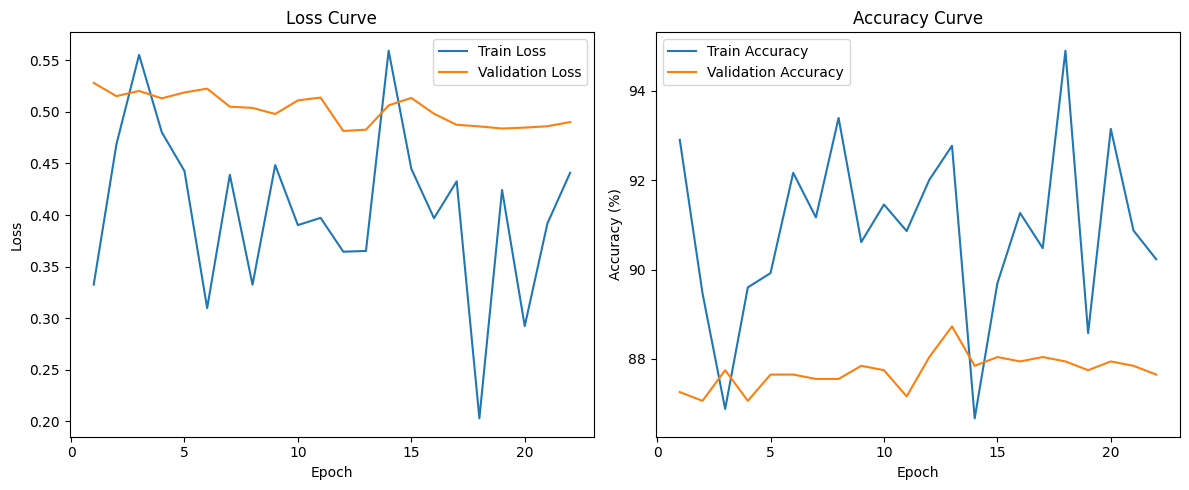

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_all_preds = []
test_all_labels = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Testing")

    for test_inputs, test_labels in test_bar:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        test_outputs = model(test_inputs)
        test_loss_batch = criterion(test_outputs, test_labels)
        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

        test_all_preds.extend(test_predicted.cpu().numpy())
        test_all_labels.extend(test_labels.cpu().numpy())

        test_bar.set_postfix(loss=test_loss_batch.item(), accuracy=100 * test_correct / test_total)

test_epoch_loss = test_loss / len(test_dataset)
test_epoch_acc = 100 * test_correct / test_total

test_accuracy = accuracy_score(test_all_labels, test_all_preds)
test_precision = precision_score(test_all_labels, test_all_preds, average='macro')
test_recall = recall_score(test_all_labels, test_all_preds, average='macro')
test_f1 = f1_score(test_all_labels, test_all_preds, average='macro')

print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
    test_epoch_loss, test_epoch_acc))
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')
print(f'GFLOPs: {macs}')

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()